# Timescales for Salinity Reintroduction after Hurricane Harvey

## Set up for analysis and read in data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib.dates import date2num
import matplotlib.dates
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
from scipy.optimize import curve_fit
pd.set_option('max_rows', 6)  # max number of rows to show in this notebook — to save space!
import shapely

In [2]:
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator(central_longitude=-85.0)

plots = {'Water Level [m]': {'color': '0.1', 'marker': 'o', 's': 200, 'alpha': 1, 'linewidths': 2}, 
         'Gage height [m]': {'marker': 'o', 's': 200, 'alpha': 1}, 
         'East [m/s]': {'color': 'w', 'marker': 'v', 's': 120, 'alpha': 1},
         'Salinity': {'color': 'w', 'marker': '*', 's': 280, 'alpha': 1}, 
         'Along [cm/s]': {'color': 'w', 'marker': '^', 's': 150, 'alpha': 1},
         'Rain [cm]': {'marker': 's', 's':200, 'alpha': 1},
         'Flow rate [m^3/s]': {'marker': '>', 's': 200, 'alpha': 1}}

b = '../data/'
baseb = b + 'bathy/'
basesf = b + 'shapefiles/'
based = b + 'stations/'

# Bathymetry was processed previously. See https://github.com/kthyng/harvey_inflow/blob/master/notebooks/Process%20bathymetry.ipynb
d = np.load(baseb + 'bathy_galv_clean.npz')  # all of Galveston Bay
bathy = d['bathy']; dx = d['dx']; dy = d['dy']; lon = d['lon']; lat = d['lat']
bathyo = np.load(baseb + 'bathy_every_fifth.npz')['bathy'][::-1,:][1:-1,1:-1]  # all
bathyo = np.ma.masked_where(bathyo>0, bathyo)

In [44]:
run buoy_info.py

<Figure size 432x288 with 0 Axes>

In [4]:
# See make_data notebook. This reads in data from many sources, recalculates so that all data is hourly by taking 
# hourly averages, and shifts water levels to all be mean high water to match the bathymetry.
df = pd.read_csv(based + 'data08to08-15min.csv', parse_dates=True, index_col=0)

dstart = '2017-08-01'; dend = '2018-08-01'

# get some datetime numbers to use in calculation
df['idx'] = date2num(df.index.to_pydatetime())

# remove bad data
df['8770613: Salinity']['2017-9-20 09:00'] = np.nan  # bad data point
df['8770613: Salinity']['2017-9-20 9:00':'2017-9-20 11:00'] = np.nan
df['B: Salinity'][df['B: Salinity'] < 18] = np.nan
df['B: Salinity'][df['B: Salinity'] > 50] = np.nan


In [5]:
# set up salinity column names
saltcols = [col for col in df.columns if 'Salinity' in col]
saltcols = [col for col in saltcols if not 'OLDR' in col]
saltcols = [col for col in saltcols if not 'B:' in col]

## Data used in study

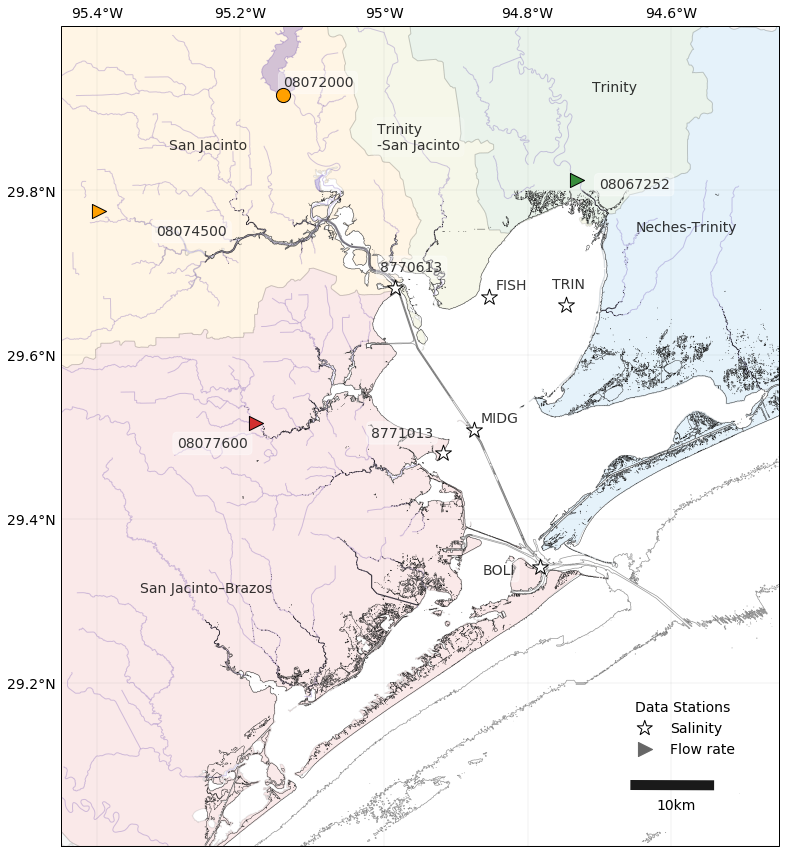

In [51]:

extent = [-95.45, -94.45, 29, 30.0]
x1, x2, y1, y2 = extent
pts = np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])
ext = shapely.geometry.Polygon(pts)


fig = plt.figure(figsize=(14, 12))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent(extent, pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.2))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.2))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry, but only near bay
# mappable = ax.contourf(lon, lat, bathyo, [-25, -20, -15, -10, -8, -6, -4, -2, 0], vmin=-40, cmap=cmo.gray, transform=pc)
# cb = fig.colorbar(mappable, orientation='horizontal', shrink=0.5, pad=0.025)
# cb.set_label('Depth [m]')

# # add background land
# ax.add_feature(land_10m)

# add bay-area detailed coastline
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

# bathymetry contours to highlight shipping lanes
ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-', alpha=0.4)  # some values


# Add river basins to plot
reader = cartopy.io.shapereader.Reader(basesf + 'Major_River_Basins_Shapefile/TWDB_MRBs_2014.shp')
basins = reader.records()
for basin in basins:
    if basin.attributes['basin_name'] == 'San Jacinto-Brazos':
        facecolor = buoys['OLDR']['color']  # 'red'
    elif basin.attributes['basin_name'] == 'San Jacinto':
        facecolor = buoys['TRIN']['color']  # 'orange'
    elif basin.attributes['basin_name'] == 'Trinity-San Jacinto':
        facecolor = buoys['8771013']['color']  # 'yellow'
    elif basin.attributes['basin_name'] == 'Trinity':
        facecolor = buoys['8771341']['color']  # 'green'
    elif basin.attributes['basin_name'] == 'Neches-Trinity':
        facecolor = buoys['8771972']['color']  # 'blue'
    else:
        facecolor = '0.7'
    ax.add_geometries([basin.geometry], pc, facecolor=facecolor, edgecolor='k', linewidth=1, alpha=0.1)

watercolor = buoys['8770808']['color']

# Add lakes to plot
reader = cartopy.io.shapereader.Reader(basesf + 'tceq_segments_2014_shp/TCEQ_SEGMENT_POLY_2014.shp')
lakes = reader.records()
for lake in lakes:
    if ext.contains(lake.geometry.centroid) and "Bay" not in lake.attributes['BASIN_NAME'] \
         and "Gulf" not in lake.attributes['BASIN_NAME']:
        ax.add_geometries([lake.geometry], pc, facecolor=watercolor, edgecolor=watercolor, alpha=0.25)

# Add rivers to plot
reader = cartopy.io.shapereader.Reader(basesf + 'tceq_segments_2014_shp/TCEQ_SEGMENT_LINE_2014.shp')
rivers = reader.records()
for river in rivers:
    if ext.contains(river.geometry.centroid):
        ax.add_geometries([river.geometry], pc, facecolor='none', edgecolor=watercolor, alpha=0.25)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.4)
        
## add buoys ##
for buoy in ['08067252','08074500','08077600','08072000','TRIN', 'FISH', 'MIDG', '8771013', '8770613', 'BOLI', ]:
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    if buoy == '08074500':
        lonsh += 0.08
    elif buoy == '08077600':
        lonsh += 0.05
    elif buoy == '8771013':
        lonsh += 0.05
    elif buoy == 'BOLI':
        latsh -= 0.03
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=14, color='0.2', bbox=props)
    for var in ['Gage height [m]','Salinity','Rain [cm]', 'Flow rate [m^3/s]']:
        if var in buoys[buoy]['vars']:
            kwargs = plots[var]
            # use buoy color in some cases
            if not 'color' in kwargs:
                color = buoys[buoy]['color']
                ax.scatter(*buoys[buoy]['ll'], **kwargs, facecolors=color, transform=pc, label=var, edgecolors='k', zorder=5)
            else:
                ax.scatter(*buoys[buoy]['ll'], **kwargs, transform=pc, label=var, edgecolors='k', zorder=5)                
                
# Add labels
ax.text(-95.3, 29.85, 'San Jacinto', transform=pc, alpha=0.8)
ax.text(-95.01, 29.85, 'Trinity\n-San Jacinto', transform=pc, alpha=0.8, bbox=dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.2))
ax.text(-95.34, 29.31, 'San Jacinto–Brazos', transform=pc, alpha=0.8)
ax.text(-94.71, 29.92, 'Trinity', transform=pc, alpha=0.8)
ax.text(-94.65, 29.75, 'Neches-Trinity', transform=pc, alpha=0.8);

# Distance key
llon, llat = -94.65, 29.075
eqproj = cartopy.crs.AzimuthalEquidistant(central_longitude=-95, central_latitude=30)
lx, ly = eqproj.transform_point(llon, llat, pc)  # convert to projection
ax.plot([lx, lx+10e3], [ly, ly], lw=10, transform=eqproj, color='0.1')
ax.text(llon+0.03, llat-0.03, '10km', transform=pc)

# Add legend
ax2 = fig.add_axes([0.72, 0.1, 0.13, 0.3], frameon=False)
ax2.scatter([], [], c='none', linewidths=1, s=250, marker='*', edgecolors='k', label='Salinity')
# ax2.scatter([], [], c='0.4', s=200, marker='s', label='Sampling')
# ax2.scatter([], [], c='0.4', s=200, marker='s', label='Precipitation')
# ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=150, marker='v', label='Wind')
ax2.scatter([], [], c='0.4', s=200, marker='>', label='Flow rate')
# ax2.scatter([], [], c='0.1', s=200, marker='o', label='Gage height')
# ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=200, marker='^', label='Velocity', alpha=1)

ax2.legend(scatterpoints=1, frameon=False, title='Data Stations', loc='lower right')
ax2.set_axis_off()

fig.savefig('../figures/map.png', bbox_inches='tight', dpi=300)
fig.savefig('../figures/map_lowres.png', bbox_inches='tight')


The dates below were chosen from the observations to reflect the start of different phases of the flooding. Outflow and sea surface rise were chosen originally in the Harvey Inflow study and shown here for context.

In [7]:
date_outflow = pd.Timestamp('2017-8-26 14:30')  # when salinity starts to drop, based on velocity
date_ssh = pd.Timestamp('2017-8-24 16:00')  # when sea surface starts to raise
date_fresh = pd.Timestamp('2017-8-30 00:00')  # all stations approximately fresh

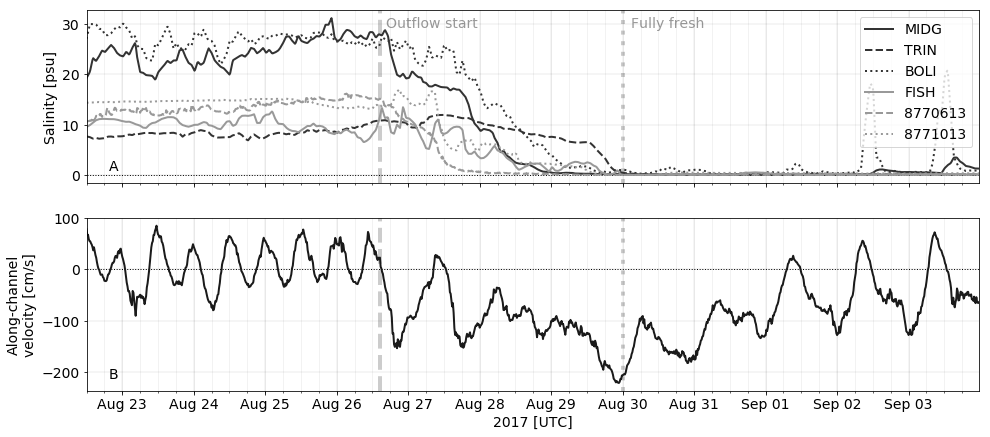

In [50]:
# define short dataframe to simplify plotting
dsp = '2017-08-22 12:00'; dep = '2017-09-3'
ddt = 1
dfsh = df.copy()[::ddt][dsp:dep]
dfsh['idx'] = date2num(pd.to_datetime(dfsh.index).to_pydatetime())
width = 0.2

date_ssh = pd.Timestamp('2017-8-24 16:00')  # when sea surface starts to raise
date_outflow = pd.Timestamp('2017-8-26 14:30')  # when salinity starts to drop, based on velocity

fig, axes = plt.subplots(2, 1, figsize=(16,7), sharex=True)

    
## Salinity ##
bs = ['MIDG', 'TRIN', 'BOLI', 'FISH', '8770613', '8771013']
linestyles = ['-', '--', ':', '-', '--', ':']
colors = ['0.2', '0.2', '0.2', '0.6', '0.6', '0.6']
for buoy, ls, col in zip(bs, linestyles, colors):
    axes[0].plot(dfsh.index, dfsh[buoy + ': Salinity'], label=buoy, color=col, lw=2, ls=ls)
axes[0].legend(loc='best')
axes[0].text(0.025, 0.072, 'A', fontsize=14, transform=axes[0].transAxes)


## Entrance along-channel velocity ##
axes[1].plot(dfsh.index, dfsh['g06010: Along [cm/s]'], color='0.1', lw=2)
axes[1].text(0.025, 0.072, 'B', fontsize=14, transform=axes[1].transAxes)


# axes[0].set_ylim(-15,15)
axes[0].set_xlim(dfsh.index[0], dfsh.index[-1])
for ax in axes:
    ax.hlines(0, dfsh.index[0], dfsh.index[-1], linewidth=1, linestyle=':')
    ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
    ax.grid(which='minor', lw=1, color='k', alpha=0.05)
    # overlay lines for events
    ylims = ax.get_ylim()
    ax.set_ylim(*ylims)
#     ax.vlines(date_ssh, *ylims, linewidth=4, alpha=0.2, color='k')
    ax.vlines(date_outflow, *ylims, linewidth=4, alpha=0.2, color='k', linestyle='--')
    ax.vlines(date_fresh, *ylims, linewidth=4, alpha=0.2, color='k', linestyle=':')

# labels
# axes[0].set_ylabel('Wind [m/s]')
# axes[1].set_ylabel('Water Level [m, MHW]')
axes[0].set_ylabel('Salinity [psu]')
axes[1].set_ylabel('Along-channel\nvelocity [cm/s]')

# label dates
# axes[0].text(0.18, 0.9, 'SSH rise', transform=axes[0].transAxes, alpha=0.4)
axes[0].text(0.335, 0.9, 'Outflow start', transform=axes[0].transAxes, alpha=0.4)
axes[0].text(0.61, 0.9, 'Fully fresh', transform=axes[0].transAxes, alpha=0.4)


minor = mpl.dates.HourLocator(byhour=np.arange(0,24,6))
ax.xaxis.set_minor_locator(minor)
major = mpl.dates.HourLocator(byhour=np.arange(0,24,24))
ax.xaxis.set_major_locator(major)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))

handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

ax.set_xlabel('2017 [UTC]')

plt.savefig('../figures/conditions.pdf', bbox_inches='tight')

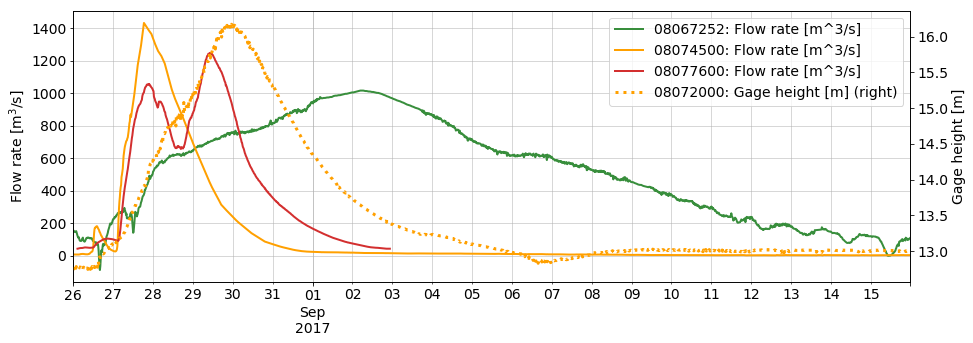

In [49]:
# df['08068090: Flow rate [m^3/s]']['2017-8-26':'2017-9-15'].plot(legend=True)
# df['08076000: Flow rate [m^3/s]']['2017-8-26':'2017-9-15'].plot(legend=True)
ax = df['08067252: Flow rate [m^3/s]']['2017-8-26':'2017-9-15'].plot(figsize=(10,3), legend=True, color=buoys['08067252']['color'],lw=2)
df['08074500: Flow rate [m^3/s]']['2017-8-26':'2017-9-15'].plot(ax=ax, legend=True, color=buoys['08074500']['color'],lw=2)
df['08077600: Flow rate [m^3/s]']['2017-8-26':'2017-9-15'].plot(ax=ax, legend=True, color=buoys['08077600']['color'],lw=2)
axt = df['08072000: Gage height [m]']['2017-8-26':'2017-9-15'].plot(figsize=(15,5), legend=True, secondary_y=True, ax=ax, 
                                                                    color=buoys['08072000']['color'], lw=3, ls=':')

ax.grid(True, which='both', linewidth=1, alpha=0.5)
ax.set_ylabel('Flow rate [m$^3$/s]')
axt.set_ylabel('Gage height [m]')
ax.autoscale(enable=True, axis='x', tight=True)
# plt.legend(['08068090', '08067252','08066500'])
plt.savefig('../figures/flow_rate.pdf', bbox_inches='tight')


## Salinity timescales

In [9]:
times = {'TRIN': {'fresh': '2017-8-30 00:00', 'start': '2017-9-17 12:00', 'stop': '2017-10-11 00:00',
                 'depths': [np.round(df['TRIN: Depth [m]']['2017-9-2 00:00':'2017-10-1 00:00'].mean())],
                 'dx': 0},
         'FISH': {'fresh': '2017-8-30 00:00', 'start': '2017-9-11 8:00', 'stop': '2017-10-11 00:00',
                 'depths': [np.round(df['FISH: Depth [m]']['2017-9-2 00:00':'2017-10-1 00:00'].mean())],
                 'dx': 0},                  
         '8770613': {'fresh': '2017-8-29 00:00', 'start': '2017-9-5 00:00', 'stop': '2017-10-11 00:00',
                    'depths': [np.round(1.58496)], 'dx': -0.04},
         'MIDG': {'fresh': '2017-8-29 00:00', 'start': '2017-9-2 00:00', 'stop': '2017-10-11 00:00',
                 'depths': [np.round(df['MIDG: Depth [m]']['2017-9-2 00:00':'2017-10-1 00:00'].mean())], 'dx': -0.04},                  
         '8771013': {'fresh': '2017-8-29 12:00', 'start': '2017-9-12 00:00', 'stop': '2017-10-11 00:00',
                    'depths': [1.28016], 'dx': 0},
         'BOLI': {'fresh': '2017-8-30 00:00', 'start': '2017-9-1 00:00', 'stop': '2017-10-11 00:00', 
                  'depths': [np.round(df['BOLI: Depth [m]']['2017-9-2 00:00':'2017-10-1 00:00'].mean())],
                  'dx': -0.04},
}

In [10]:
# plotting choices
colorlag = '#144997' 
colorefold = '#5CC687'
color12 = '#ECDC5E'

shift = {'TRIN': (0.01,0.01), 'FISH': (0.01,0.01), '8770613': (-0.03,0.02), 'MIDG': (0.01,0.01),
      '8771013': (-0.06,0.02), 'BOLI': (0.0,0.02)}

### Recovery based on absolute salinity values

In [28]:
# Start time scale dictionary, tau
tau = dict()

for key in times.keys():
    tau[key] = dict()
    tau[key]['lag'] = (pd.Timestamp(times[key]['start']) - date_fresh).total_seconds()/86400

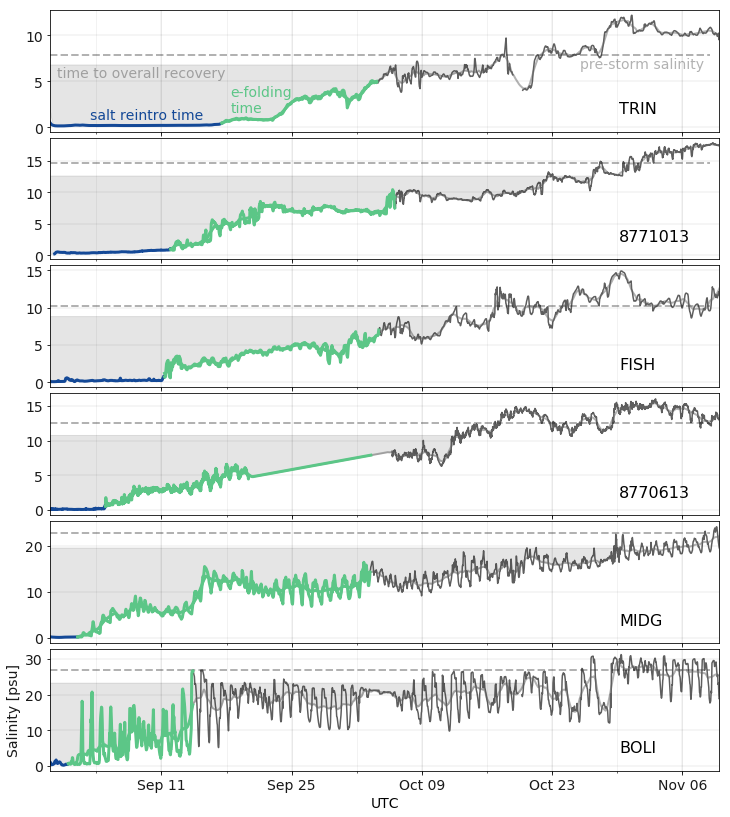

In [29]:
cols = ['TRIN: Salinity', '8771013: Salinity', 'FISH: Salinity', '8770613: Salinity', 'MIDG: Salinity', 'BOLI: Salinity']

dst = date_fresh; den = '2017-11-09'; denfull = '2017-12-31'  # '2017-10-15'
fig, axes = plt.subplots(len(saltcols), 1, figsize=(12,14), sharex=True)
fig.subplots_adjust(hspace=0.05)

taus = np.empty(len(saltcols))
for j, (col, ax) in enumerate(zip(cols, axes)):

    # Station name
    name = col.split(':')[0]

    start = times[name]['start']  # start is specific to each data station
    tnums = df['idx'][start:den] - df['idx'][start]  # decimal days
    # 1 day rolling mean
    dfmean = df[col].interpolate().rolling(center=True, window=24*4*1).mean()
    dfshort = dfmean[start:denfull]  # shortened filtered dataframe for analysis
    
    # S0 is the "initial" salinity before flooding, the average over several days
    S0 = df[col][date_ssh-pd.Timedelta('3 days'):date_ssh].mean()
    
    ## e-folding variables ##
    # time at 37%*S0 salinity, datetime when efolding time happens
    time37 = dfshort.index[np.where((1-dfshort/S0)<=np.exp(-1))[0][0]]
    # save e folding tau, in units of days
    tau[name]['efold'] = (time37 - pd.Timestamp(start)).total_seconds()/86400  

    ## overall recovery variables ##
    fover = np.exp(-2)
    # datetime for overall "recovery"
    time_over = dfshort.index[np.where((1-dfshort/S0) <= fover)[0][0]]
    # tau for overall recovery, in units of days
    tau[name]['time_over'] = tau[name]['lag'] + (time_over - pd.Timestamp(start)).total_seconds()/86400  # save lag + flooding time to 12% S0, in days

    # 3 e fold #
    f3e = np.exp(-3)
    t3e = dfshort.index[np.where((1-dfshort/S0) <= f3e)[0][0]]
    tau[name]['3e'] = tau[name]['lag'] + (t3e - pd.Timestamp(start)).total_seconds()/86400 

    # 5 e fold #
    f5e = np.exp(-5)
    t5e = dfshort.index[np.where((1-dfshort/S0) <= f5e)[0][0]]
    tau[name]['5e'] = tau[name]['lag'] + (t5e - pd.Timestamp(start)).total_seconds()/86400 

    # 6 e fold #
    f6e = np.exp(-6)
    t6e = dfshort.index[np.where((1-dfshort/S0) <= f6e)[0][0]]
    tau[name]['6e'] = tau[name]['lag'] + (t6e - pd.Timestamp(start)).total_seconds()/86400 
    
    
    ## plot ##
    color = '0.1'
    # Full resolution data
    ax.plot(df[dst:den].index, df[col][dst:den], color=color, alpha=0.7)
    # Overlay rolling mean data
    ax.plot(dfshort[dst:den], color='0.4', lw=2, alpha=0.5)
    
    ax.tick_params(labelcolor=color)
    
    # Overlay lag time
    tstrlag = date_fresh + pd.Timedelta(str(tau[name]['lag']) + 'days')
    ax.plot(df[date_fresh:tstrlag].index, df[col][date_fresh:tstrlag], color=colorlag, lw=3)
    
    # Overlay e-folding time
    tstrefold = pd.Timestamp(start) + pd.Timedelta(str(tau[name]['efold']) + 'days')
    ax.plot(df[start:tstrefold].index, df[col][start:tstrefold], color=colorefold, lw=3)  # data
    ax.plot(dfshort[:tstrefold].index, dfshort[:tstrefold], color=colorefold, lw=3)  # rolling mean data
    
    # overlay time to overall recovery
    tstrover = date_fresh + pd.Timedelta(str(tau[name]['time_over']) + 'days')
    ax.fill_between(dfmean[date_fresh:tstrover].index, dfmean[date_fresh:tstrover], S0*(1-fover), color='k', alpha=0.1)
    
    # write station name and tau
    ax.text(0.85, 0.15, name, transform=ax.transAxes, fontsize=16)
    
    # minor ticks weekly
    week = mpl.dates.DayLocator(interval=7)
    ax.xaxis.set_minor_locator(week)

    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
    ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
    ax.grid(which='minor', lw=1, color='k', alpha=0.05)
    
    if j==0:
        axes[0].text(pd.Timestamp('2017-10-26 00:00'), S0-1.5, 'pre-storm salinity', color='k', alpha=0.3)
    if j==len(axes)-1:
        ax.set_ylabel('Salinity [psu]', color=color)
    ax.hlines(S0, df.loc[dst,:].idx, df.loc[den,:].idx, color='k', linewidth=2, alpha=0.3, linestyle='--')
    
# labels, label timescales, and S0
axes[0].text(0.06, 0.1, 'salt reintro time', transform=axes[0].transAxes, color=colorlag)
axes[0].text(0.27, 0.16, 'e-folding\ntime', transform=axes[0].transAxes, color=colorefold)
axes[0].text(0.01, 0.45, 'time to overall recovery', transform=axes[0].transAxes, color='k', alpha=0.3)
axes[-1].set_xlabel('UTC')
axes[-1].autoscale(enable=True, axis='x', tight=True)


fig.savefig('../figures/times.pdf', bbox_inches='tight')

In [30]:
for key in tau.keys():
    print(key)
    for tauname in tau[key].keys():
        print('%s %2.2f' % (tauname, tau[key][tauname]))

TRIN
lag 18.50
efold 16.64
time_over 47.62
3e 48.29
5e 48.57
6e 48.58
FISH
lag 12.33
efold 23.03
time_over 43.14
3e 47.71
5e 47.89
6e 47.90
8770613
lag 6.00
efold 28.52
time_over 44.61
3e 47.89
5e 48.15
6e 48.18
MIDG
lag 3.00
efold 31.43
time_over 61.24
3e 71.31
5e 72.35
6e 72.40
8771013
lag 13.00
efold 24.07
time_over 58.49
3e 58.86
5e 62.26
6e 63.50
BOLI
lag 2.00
efold 13.38
time_over 51.02
3e 60.62
5e 60.71
6e 60.72


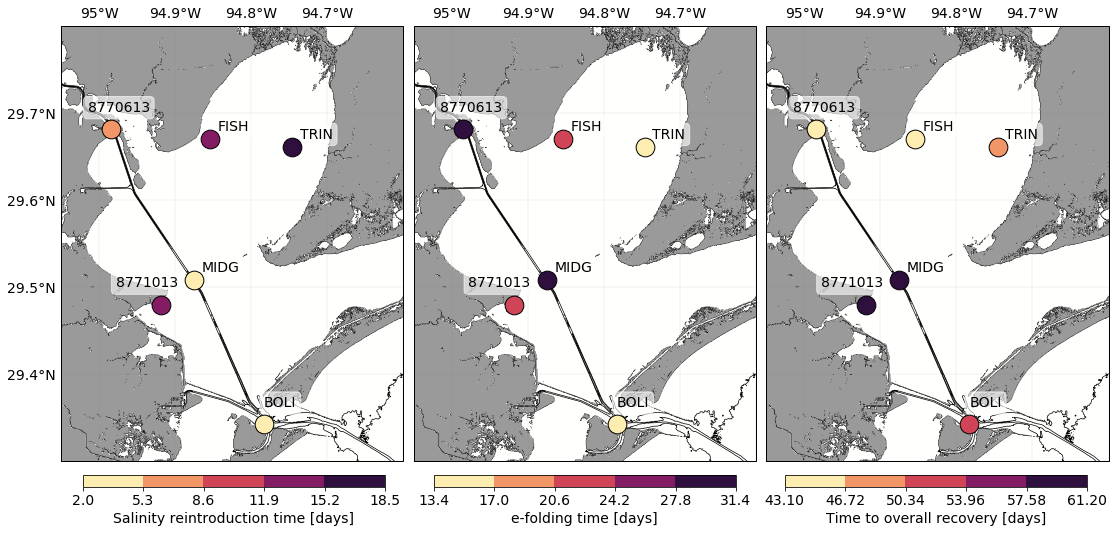

In [22]:
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.6)
marker = 'o'
zorder = 10
s = 350
cmap = cmo.matter

types = ['lag', 'efold', 'time_over']
typenames = ['Salinity reintroduction time', 'e-folding time', 'Time to overall recovery']

fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(wspace=0.03, left=0.01, right=0.98)

for i, (which, whichname) in enumerate(zip(types, typenames)):
    ax = fig.add_subplot(1,3,i+1, projection=merc)
    ax.set_extent([-95.05, -94.6, 29.3, 29.8], pc)
    gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.1))
    gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.1))
    gl.xlabels_bottom = False  # turn off labels where you don't want them
    gl.ylabels_right = False
    if i in [1,2]:
        gl.ylabels_left = False

    # bathymetry contours
    ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-')  # some values

    # add bay-area detailed coastline
    ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

    # color land
    ax.pcolormesh(lon, lat, bathyo.mask, cmap=cmo.gray_r, vmin=0, vmax=3, transform=pc)

    # range of data
    data = np.asarray([tau[key][which] for key in tau.keys()])
    vmin = data.min(); vmax = data.max()
    
    
    # define the bins and normalize
    bounds = np.linspace(np.round(vmin, decimals=1), np.round(vmax, decimals=1), 6)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    for saltcol in saltcols:
        buoy = saltcol.split(':')[0]
        sdx, sdy = shift[buoy]

        # plot data
        lonsta, latsta = buoys[buoy]['ll']
        param = tau[buoy][which]
        mappable = ax.scatter(lonsta, latsta, c=param, s=s, transform=pc, zorder=zorder, norm=norm, 
                              vmin=vmin, vmax=vmax, cmap=cmap, edgecolors='k', marker=marker)
        ax.text(lonsta+sdx, latsta+sdy, buoy, transform=pc, bbox=props)    
    
    
    # colorbar by hand
    ax2 = fig.add_axes([0.03+i*.325, 0.08, 0.28, 0.02])
    cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                    norm=norm,
                                    # to use 'extend', you must
                                    # specify two extra boundaries:
                                    boundaries=bounds,
                                    ticks=bounds,  # optional
                                    spacing='proportional', orientation='horizontal')
    cb2.set_label(whichname + ' [days]')
fig.savefig('../figures/timescales_map_low.png', bbox_inches='tight')
fig.savefig('../figures/timescales_map.png', bbox_inches='tight', dpi=300)

### Recovery, normalized by relationship with shelf salinity

In [31]:
# Start time scale dictionary, tau
tau = dict()

for key in times.keys():
    tau[key] = dict()
    tau[key]['lag'] = (pd.Timestamp(times[key]['start']) - date_fresh).total_seconds()/86400

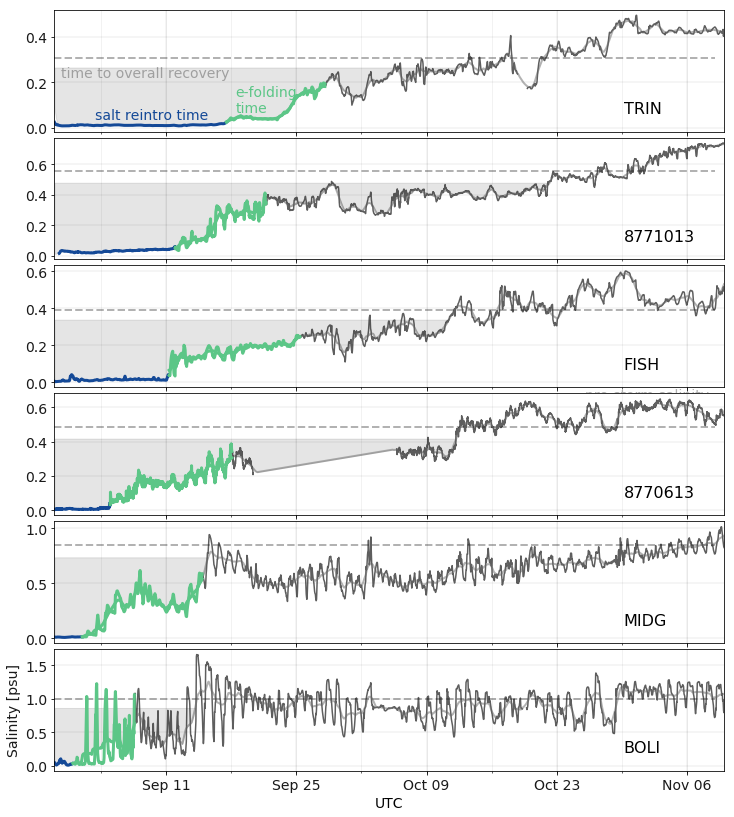

In [32]:
cols = ['TRIN: Salinity', '8771013: Salinity', 'FISH: Salinity', '8770613: Salinity', 'MIDG: Salinity', 'BOLI: Salinity']

S = df['B: Salinity'].interpolate()
norm0 = (df['BOLI: Salinity']/S)[date_ssh-pd.Timedelta('3 days'):date_ssh].mean()

dst = date_fresh; den = '2017-11-09'  # '2017-10-15'
fig, axes = plt.subplots(len(saltcols), 1, figsize=(12,14), sharex=True)
fig.subplots_adjust(hspace=0.05)

taus = np.empty(len(saltcols))
for j, (col, ax) in enumerate(zip(cols, axes)):

    # Station name
    name = col.split(':')[0]

    start = times[name]['start']  # start is specific to each data station
    tnums = df['idx'][start:den] - df['idx'][start]  # decimal days

    norm = S*norm0
    
    # rename normed function
    dfnorm = df[col]/norm

    # 1 day rolling mean
    dfmean = dfnorm.interpolate().rolling(center=True, window=24*4*1).mean()
    dfshort = dfmean[start:den]  # shortened filtered dataframe for analysis
    
    # S0 is the "initial" salinity before flooding, the average over several days
    S0 = dfnorm[date_ssh-pd.Timedelta('3 days'):date_ssh].mean()

    ## e-folding variables ##
    # time at 37%*S0 salinity, datetime when efolding time happens
    time37 = dfshort.index[np.where((1-dfshort/S0)<=np.exp(-1))[0][0]]
    # save e folding tau, in units of days
    tau[name]['efold'] = (time37 - pd.Timestamp(start)).total_seconds()/86400  

    ## overall recovery variables ##
    fover = np.exp(-2)
    # datetime for overall "recovery"
    time_over = dfshort.index[np.where((1-dfshort/S0) <= fover)[0][0]]
    # tau for overall recovery, in units of days
    tau[name]['time_over'] = tau[name]['lag'] + (time_over - pd.Timestamp(start)).total_seconds()/86400  # save lag + flooding time to 12% S0, in days

    # 3 e fold #
    f3e = np.exp(-3)
    t3e = dfshort.index[np.where((1-dfshort/S0) <= f3e)[0][0]]
    tau[name]['3e'] = tau[name]['lag'] + (t3e - pd.Timestamp(start)).total_seconds()/86400 

    # 5 e fold #
    f5e = np.exp(-5)
    t5e = dfshort.index[np.where((1-dfshort/S0) <= f5e)[0][0]]
    tau[name]['5e'] = tau[name]['lag'] + (t5e - pd.Timestamp(start)).total_seconds()/86400 

    # 6 e fold #
    f6e = np.exp(-6)
    t6e = dfshort.index[np.where((1-dfshort/S0) <= f6e)[0][0]]
    tau[name]['6e'] = tau[name]['lag'] + (t6e - pd.Timestamp(start)).total_seconds()/86400 

    ## plot ##
    color = '0.1'
    # Full resolution data
    ax.plot(dfnorm[dst:den].index, (dfnorm[dst:den]), color=color, alpha=0.7)
    # Overlay rolling mean data
    ax.plot(dfshort, color='0.4', lw=2, alpha=0.5)
    
    ax.tick_params(labelcolor=color)
    
    # Overlay lag time
    tstrlag = date_fresh + pd.Timedelta(str(tau[name]['lag']) + 'days')
    ax.plot(dfnorm[date_fresh:tstrlag].index, dfnorm[date_fresh:tstrlag], color=colorlag, lw=3)
    
    # Overlay e-folding time
    tstrefold = pd.Timestamp(start) + pd.Timedelta(str(tau[name]['efold']) + 'days')
    ax.plot(dfnorm[start:tstrefold].index, dfnorm[start:tstrefold], color=colorefold, lw=3)  # data
    ax.plot(dfshort[:tstrefold].index, dfshort[:tstrefold], color=colorefold, lw=3)  # rolling mean data
    
    # overlay time to overall recovery
    tstrover = date_fresh + pd.Timedelta(str(tau[name]['time_over']) + 'days')
    ax.fill_between(dfmean[date_fresh:tstrover].index, dfmean[date_fresh:tstrover], S0*(1-fover), color='k', alpha=0.1)
    
    # write station name and tau
    ax.text(0.85, 0.15, name, transform=ax.transAxes, fontsize=16)
    
    # minor ticks weekly
    week = mpl.dates.DayLocator(interval=7)
    ax.xaxis.set_minor_locator(week)

    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
    ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
    ax.grid(which='minor', lw=1, color='k', alpha=0.05)
    
    if j==0:
        axes[0].text(pd.Timestamp('2017-10-26 00:00'), S0-1.5, 'pre-storm salinity', color='k', alpha=0.3)
    if j==len(axes)-1:
        ax.set_ylabel('Salinity [psu]', color=color)
    ax.hlines(S0, df.loc[dst,:].idx, df.loc[den,:].idx, color='k', linewidth=2, alpha=0.3, linestyle='--')
    
# labels, label timescales, and S0
axes[0].text(0.06, 0.1, 'salt reintro time', transform=axes[0].transAxes, color=colorlag)
axes[0].text(0.27, 0.16, 'e-folding\ntime', transform=axes[0].transAxes, color=colorefold)
axes[0].text(0.01, 0.45, 'time to overall recovery', transform=axes[0].transAxes, color='k', alpha=0.3)
axes[-1].set_xlabel('UTC')
axes[-1].autoscale(enable=True, axis='x', tight=True)


fig.savefig('../figures/times_norm.pdf', bbox_inches='tight')

In [33]:
for key in tau.keys():
    print(key)
    for tauname in tau[key].keys():
        print('%s %2.2f' % (tauname, tau[key][tauname]))

TRIN
lag 18.50
efold 10.57
time_over 43.46
3e 47.96
5e 48.23
6e 48.26
FISH
lag 12.33
efold 14.04
time_over 42.40
3e 42.82
5e 43.03
6e 43.05
8770613
lag 6.00
efold 13.07
time_over 43.20
3e 43.44
5e 43.59
6e 43.61
MIDG
lag 3.00
efold 12.88
time_over 16.53
3e 66.67
5e 69.42
6e 69.92
8771013
lag 13.00
efold 9.74
time_over 53.23
3e 53.91
5e 58.56
6e 58.58
BOLI
lag 2.00
efold 6.61
time_over 15.15
3e 15.25
5e 15.30
6e 15.31


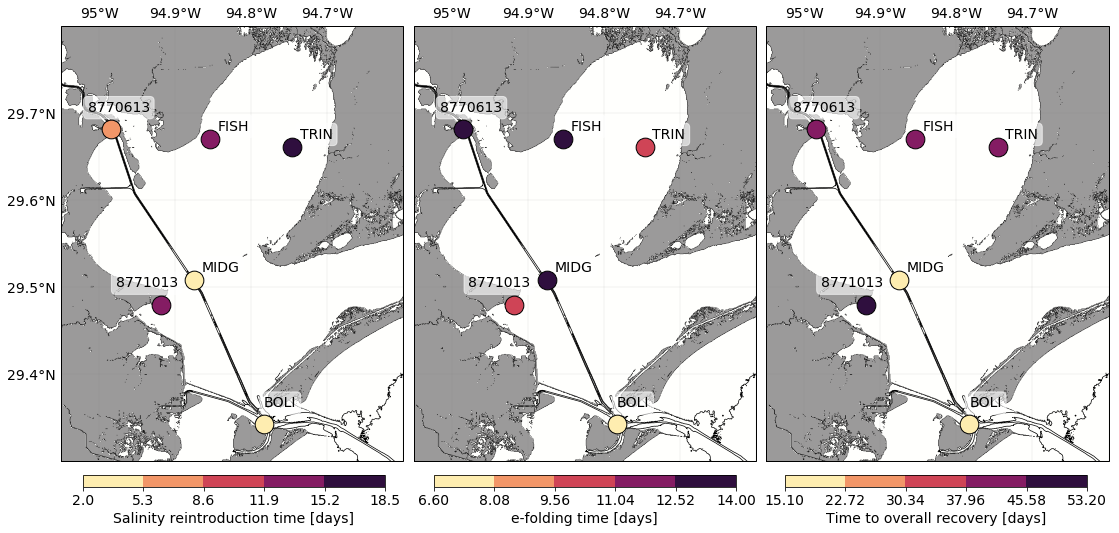

In [26]:
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.6)
marker = 'o'
zorder = 10
s = 350
cmap = cmo.matter

types = ['lag', 'efold', 'time_over']
typenames = ['Salinity reintroduction time', 'e-folding time', 'Time to overall recovery']

fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(wspace=0.03, left=0.01, right=0.98)

for i, (which, whichname) in enumerate(zip(types, typenames)):
    ax = fig.add_subplot(1,3,i+1, projection=merc)
    ax.set_extent([-95.05, -94.6, 29.3, 29.8], pc)
    gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.1))
    gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.1))
    gl.xlabels_bottom = False  # turn off labels where you don't want them
    gl.ylabels_right = False
    if i in [1,2]:
        gl.ylabels_left = False

    # bathymetry contours
    ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-')  # some values

    # add bay-area detailed coastline
    ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

    # color land
    ax.pcolormesh(lon, lat, bathyo.mask, cmap=cmo.gray_r, vmin=0, vmax=3, transform=pc)

    # range of data
    data = np.asarray([tau[key][which] for key in tau.keys()])
    vmin = data.min(); vmax = data.max()
    
    # define the bins and normalize
    bounds = np.linspace(np.round(vmin, decimals=1), np.round(vmax, decimals=1), 6)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    for saltcol in saltcols:
        buoy = saltcol.split(':')[0]
        sdx, sdy = shift[buoy]

        # plot data
        lonsta, latsta = buoys[buoy]['ll']
        param = tau[buoy][which]
        mappable = ax.scatter(lonsta, latsta, c=param, s=s, transform=pc, zorder=zorder, norm=norm, 
                              vmin=vmin, vmax=vmax, cmap=cmap, edgecolors='k', marker=marker)
        ax.text(lonsta+sdx, latsta+sdy, buoy, transform=pc, bbox=props)    
    
    
    # colorbar by hand
    ax2 = fig.add_axes([0.03+i*.325, 0.08, 0.28, 0.02])
    cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                    norm=norm,
                                    # to use 'extend', you must
                                    # specify two extra boundaries:
                                    boundaries=bounds,
                                    ticks=bounds,  # optional
                                    spacing='proportional', orientation='horizontal')
    cb2.set_label(whichname + ' [days]')
fig.savefig('../figures/timescales_norm_map_low.png', bbox_inches='tight')
fig.savefig('../figures/timescales_norm_map.png', bbox_inches='tight', dpi=300)